# CAPM

This notebook summarizes the implications of CAPM and then tests them by OLS.

## Load Packages and Extra Functions

In [1]:
using Printf, DelimitedFiles, Statistics

include("jlFiles/printmat.jl")
include("jlFiles/OlsGMFn.jl")            #contains a function for OLS

OlsGMFn

In [2]:
using Plots, LaTeXStrings

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :png)

# The Theoretical Predictions of CAPM

The following section illustrates the theoretical predictions of CAPM by taking the following steps: 

1. define a set of investable assets
2. find the tangency portfolio
3. calculate the betas of each asset against the tangency portfolio
4. check whether the average returns are in accordance with CAPM ($\text{E}R_{i}  = R_f + \beta_{i}(\mu_{T}-R_f)$).

## Characteristics of Three Assets: Means, Variances and Covariances

In [3]:
μ = [0.115, 0.095, 0.06]    #expected returns
Σ = [166  34  58;           #covariance matrix
      34  64   4;
      58   4 100]/100^2
Rf = 0.03

assetNames = ["A","B","C"]

printblue("expected returns:")
printmat(μ,rowNames=assetNames)

printblue("covariance matrix:")
printmat(Σ,colNames=assetNames,rowNames=assetNames)

expected returns:
A     0.115
B     0.095
C     0.060

covariance matrix:
          A         B         C
A     0.017     0.003     0.006
B     0.003     0.006     0.000
C     0.006     0.000     0.010



## The Tangency Portfolio

The file included below contains, among other things, the function `MVTangencyP()` from the chapter on MV analysis. It calcuates the tangency portfolio.

In [4]:
include("jlFiles/MvCalculations.jl")

MVTangencyP

In [5]:
(wT,μT,σT) = MVTangencyP(μ,Σ,Rf)
printblue("Tangency portfolio weights:")
printmat(wT,rowNames=assetNames)

Tangency portfolio weights:
A     0.248
B     0.682
C     0.070



## (Theoretical) β of the Assets

The tangency portfolio is a portfolio of the investable assets ($R_T=w_T'R$). It is therefore straightforward to calculate the covariance of each of the assets with $R_T$. The $\beta$ values are then obtained by dividing the covariances with the variance of $R_T$. 

Details: 

The covariance of $R_i$ and $R_T$, $\sigma_{iT} = w_i'\Sigma w_T$ where $w_i$ is the (sometimes trivial) portfolio that creates return $R_i$. Then, calculate $\beta_i = \sigma_{iT}/\sigma_{TT}$.

In [6]:
n = length(μ)                     #no. assets

β = fill(NaN,n)                   #n-vector
for i = 1:n
    #local wi                     #local/global is needed in script
    wi     = zeros(n)
    wi[i]  = 1                    #weight 1 on asset i
    β[i]   = wi'Σ*wT/σT^2         #usual OLS coefficient: Cov(x,y)/Var(x)
end

printblue("β of the $n assets:")
printmat(β,rowNames=assetNames)

β of the 3 assets:
A     1.259
B     0.963
C     0.444



## Trying CAPM on the Assets

CAPMS says that

$\text{E}R_i  = R_f + \beta_i(\mu_T-R_f)$ or equivalently $\text{E}R_i^e  = \beta_i \mu_T^e$
 
This can be compared with the (actual) average returns. (If we have done the previous calculations correctly, then CAPM should hold for assets $A$,$B$ and $C$).

In [7]:
ERi_CAPM = Rf .+ β*(μT-Rf)      #ERi_CAPM is a vector since β is a vector

printblue("μ and ER as suggested by CAPM: ")
printmat([μ ERi_CAPM],rowNames=assetNames,colNames=["actual","from CAPM"])

μ and ER as suggested by CAPM: 
     actual from CAPM
A     0.115     0.115
B     0.095     0.095
C     0.060     0.060



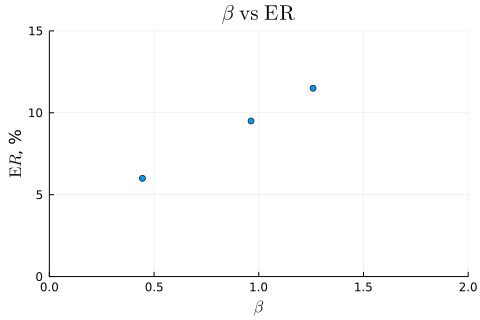

In [8]:
p1 = scatter( β,ERi_CAPM*100,      #points on the security market line
              xlim = (0,2),         
              ylim = (0,15),
              legend = false,
              title = L"\beta \mathrm{\ vs \ ER}",
              xlabel = L"\beta",
              ylabel = L"$\mathrm{E}R$, %" )
display(p1)

# An Empirical Test of CAPM 

The next section performs an empirical test of CAPM. First, we load data. Then, we run linear regressions and test whether the intercepts are zero (the CAPM prediction) or not. (We test each asset separately.)

## Loading Data

In [9]:
x    = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)
Rme  = x[:,2]                #market excess return
RSMB = x[:,3]                #small minus big firms
RHML = x[:,4]                #high minus low book-to-market ratio
Rf   = x[:,5]                #interest rate


x  = readdlm("Data/FF25Ps.csv",',') #no header line: x is matrix
R  = x[:,2:end]                     #returns for 25 FF portfolios
Re = R .- Rf                        #excess returns for the 25 FF portfolios
Re = Re[:,[1;7;13;19;25]]           #use just 5 assets to make the printing easier 

(T,n) = size(Re)                    #no. obs and  no. test assets

(388, 5)

## OLS Estimation and Testing α = 0

We now use the market return as a proxy for the tangency portfolio - and test if CAPM holds for the test assets.

To do that, we estimate $(\alpha_{i},b_{i})$ in the CAPM regression

$R_{it}^{e}  =\alpha_{i}+\beta_{i}R_{mt}^{e}+\varepsilon_{it}$

and then test if $\alpha_{i}=0$. This corresponds the CAPM prediction that $\text{E}R_i^e  = \beta_i \mu_m^e$.


### A Remark on the Code

- The function `OlsGMFn` is included in the file `OlsGMFn.jl` (see the first cell of the notebook). It does OLS estimation and reports the point estimates, residuals and more. The variance-covariance matrix of the coefficients is based on the Gauss-Markov assumptions.
- In the call on `printmat()`, `;colNames` (notice: semicolon) is the same as `,colNames=colNames`.

In [10]:
x = [ones(T) Rme]                   #regressors

(α,tstat) = (fill(NaN,n),fill(NaN,n))
for i = 1:n                              #loop over the different test assets
    #local b_i, residual, Covb           #local/global is needed in script
    (b_i,_,_,Covb,) = OlsGMFn(Re[:,i],x)
    α[i]            = b_i[1]                      #estimated α
    tstat[i]        = (α[i]-0)/sqrt(Covb[1,1])    #tstat of H₀: true α=0
end

printblue("OLS intercepts and t-stats:")
colNames = [string("asset ",i) for i=1:n]
rowNames = ["α","t-stat"]
printmat([α';tstat'];colNames,rowNames)

OLS intercepts and t-stats:
         asset 1   asset 2   asset 3   asset 4   asset 5
α         -0.504     0.153     0.305     0.279     0.336
t-stat    -1.656     1.031     2.471     2.163     2.073

